# Case 5b: Bayesian inference of model parameters using Turing.jl

## Important!

Performing inference with Turing.jl is not as flexible as it would be with Stan. However, it's usage is simpler and everything works within Julia, so no need to install CmdStan separatelly. Note that inferences will not be called within BOMBs, but don't worry, things have been set so that running inferences is as easy as possible. Additionally, Turing.jl presents different inference methods that could better accomodate to the user's needs. For more information visit https://turing.ml/dev/ 


Also, to be able to use Turing you need to import Turing.jl and MCMCChains.jl (using Turing; using MCMCChains) since these are not included as dependencies of BOMBs. The main Turing model generated already imports these, so just make sure to have them installed. 


In this section we will use the usual PLac model (model 1) as well as the Hes1 model (model 2) reported in "Liepe J, Filippi S, Komorowski M, Stumpf MPH (2013) **Maximizing the Information Content of Experiments in Systems Biology**. PLOS Computational Biology 9(1): e1002888. https://doi.org/10.1371/journal.pcbi.1002888"

In [2]:
using BOMBs

### Just to print the nice BOMBS logo

In [3]:
printBOMBsLogo()


                      ___________   __________   ___  ___   ___________   __________
                     /  _____   /  / ______  /  /   \/   \  \   _____  \  \  _______\
                    /  /____/  /  / /     / /  /          \  \  \____\  \  \ \________
                   /  _____   /  / /     / /  /            \  \   _____  \  \________ \
                  /  /    /  /  / /     / /  /   /\____/\   \  \  \    \  \          \ \
                 /  /____/  /  / /_____/ /  /   /        \   \  \  \____\  \   _______\ \
                /__________/  /_________/  /__ /          \___\  \__________\  \_________\

                


First we need to generate the models (the package will not do it automatically)

In [4]:
# Generate the empty dictionary with the model_def1 structure
model_def1 = defModStruct()

# Fill the different elements of the dictionary with your model specifications. See above how ^
model_def1["NameF"] = ["PLacExample"];
model_def1["nStat"] = [4];
model_def1["nPar"] = [9];
model_def1["nInp"] = [1];
model_def1["stName"] = ["Cit_mrna","Cit_foldedP","Cit_fluo","Cit_AU"];

model_def1["inpName"] = ["IPTG"];

model_def1["parName"] = ["alpha1","Vm1","h1","Km1","d1",
                            "alpha2","d2","Kf","sc_molec"];
model_def1["eqns"] = ["dCit_mrna=alpha1+Vm1*(IPTG^h1/(Km1^h1+IPTG^h1))-d1*Cit_mrna",
                    "dCit_foldedP=alpha2*Cit_mrna-(d2+Kf)*Cit_foldedP",
                    "dCit_fluo=Kf*Cit_foldedP-d2*Cit_fluo",
                    "dCit_AU = sc_molec*dCit_fluo"];

model_def1["Y0eqs"] = ["Cit_mrna = (alpha1 + Vm1*(IPTG^h1/(Km1^h1+IPTG^h1)))/d1;",
                      "Cit_foldedP = (alpha2*Cit_mrna)/(Kf+d2);",
                      "Cit_fluo = (Kf*Cit_foldedP)/d2;",
                      "Cit_AU= sc_molec*Cit_fluo;"]; 

model_def1["Y0Sim"] = [];
model_def1["tols"] = [1e-9, 1e-9];

# Generate the scripts with the ODEs and the step-wise implementation
model_def1 = GenerateModel(model_def1);


----------------------------------------- MODEL GENERATION -----------------------------------------
The model has been generated in the directory: 
                 E:\UNI\D_Drive\PhD\JULIAlang\Generalisation_PLacExample\TuringTests\TuringExampleFinal\ModelsFunctions\PLacExample_Model.jl
--------------------------------------------------------------------------------------



In [5]:
model_def2 = defModStruct()
# Fill the different elements of the dictionary with your model specifications. See above how ^
model_def2["NameF"] = ["Hes1Example"];
model_def2["nStat"] = [3];
model_def2["nPar"] = [4];
model_def2["nInp"] = [1];
model_def2["stName"] = ["m","p1","p2"];

model_def2["inpName"] = ["inps"];

model_def2["parName"] = ["k1","P0","v","h"];

model_def2["eqns"] = ["dm = -0.03*m + (1/(1+(p2/P0)^h))*inps",
                    "dp1 = -0.03*p1 + v*m - k1*p1",
                    "dp2 = -0.03*p2 + k1*p1"];

model_def2["Y0eqs"] = []; 

model_def2["Y0Sim"] = [];
model_def2["tols"] = [1e-9, 1e-9];
model_def2["solver"]="Tsit5";

# Generate the scripts with the ODEs and the step-wise implementation
model_def2 = GenerateModel(model_def2);


----------------------------------------- MODEL GENERATION -----------------------------------------
The model has been generated in the directory: 
                 E:\UNI\D_Drive\PhD\JULIAlang\Generalisation_PLacExample\TuringTests\TuringExampleFinal\ModelsFunctions\Hes1Example_Model.jl
--------------------------------------------------------------------------------------



### This function gives you information about the structure necessary to generate the model and how to call it. 
If you do not know how to call a specific section, just call the function with no input (infoAll()) to get the information.

In [6]:
infoAll("turing")



                CALL defTurInfStruct()

            MAIN STRUCTURE

    turinf_def["Priors"] = []; # Three options for this:
            # 1) A 2*N array containing the bounds for the parameters. Order of parameters will be assumed as
                # the one introduced in model_def["parName"]. As a prior a truncated Normal covering 2
                # standard deviations in the bounds given will be generated as prior.
            # 2) Path to a CSV file containing samples for the parameters. Fitting of the samples to
                # different type of distributions will be done to generate the priors. Order of parameters
                # will be assumed as the one introduced in model_def["parName"]. You can also
                # introduce a 2D array of floats with the samples (Array{Float64,2}).
            # 3) Array containing any distribution from the Julia package Distributions.jl with their
                # corresponding parameters. Order of parameters will be assumed as
 

# Turing Inference Example 1
This example will not run an inference, but it will generate all the necessary scripts and structures to run the turing inference later on. In this case we will use model 1 (PLac).  

First we need to define the section structure, which is highly similar to the one used in the Stan section

In [6]:
turinf_def = defTurInfStruct()

Dict{Any,Any} with 6 entries:
  "Priors"       => Any[]
  "flag"         => Any[]
  "plot"         => Any[]
  "Data"         => Any[]
  "Trunc"        => Any[]
  "MultiNormFit" => Any[]

For now we will ignore the field Priors and Trunc, we will get into it in a moment. 

In [7]:
turinf_def["Data"] = defBayInfDataFromFilesStruct();
turinf_def["flag"] = ["test"]; 
turinf_def["plot"] = [true]; 
turinf_def["MultiNormFit"] = [true];

**Important!** \
Note that to extract the experimental data we are using the same function used in the Stan section. Both sections share the same function, so there is no additional one, neither for data introduced by the user or given as CSV files. 

If the data given has multiple traces for the observables, this will rise problems in posterior steps. Note that in this case, multivariate likelihoods are not supported yet when using Turing.jl in BOMBs. 

In [8]:
turinf_def["Data"]["Observables"] = ["PseudoDataFiles\\TestPLac_EXP1_Example1b_Observables.csv", "PseudoDataFiles\\TestPLac_EXP2_Example1b_Observables.csv"];
turinf_def["Data"]["Inputs"] = ["PseudoDataFiles\\TestPLac_EXP1_Example1_Events_Inputs.csv", "PseudoDataFiles\\TestPLac_EXP2_Example1_Events_Inputs.csv"];
turinf_def["Data"]["Obs"] = ["3*Cit_AU"];
turinf_def["Data"]["y0"] = [[1,1,1,1],[1,1,1,1]];

#### Now, let's have a look at the different options you can use in order to define the prior

Note that differently than the Stan section, a transformation of the distributions will never be done automatically in BOMBs

A 2*N (where N is the number of parameters) array with the parameter bounds. This will generate a wide truncated normal prior for each parameter (independent)

In [9]:
turinf_def["Priors"] = [0.4950 0.4950 4.9 10 0.23 6.8067 0.2449 0.0217 10;
3.88e-5 3.88e-2 0.5 2 7.7e-3 0.2433 5.98e-5 0.012 0.001]; 

In [10]:
turinf_def = checkStructTurInf(model_def1, turinf_def);

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = read(::String) at CSV.jl:46
└ @ CSV C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\CSV\UIgP3\src\CSV.jl:46


In [11]:
turinf_def["Priors"]

9-element Array{Any,1}:
 Truncated(Distributions.Normal{Float64}(μ=0.2475194, σ=0.1237403), range=(3.88e-5, 0.495))
 Truncated(Distributions.Normal{Float64}(μ=0.2669, σ=0.11405), range=(0.0388, 0.495))
 Truncated(Distributions.Normal{Float64}(μ=2.7, σ=1.1), range=(0.5, 4.9))
 Truncated(Distributions.Normal{Float64}(μ=6.0, σ=2.0), range=(2.0, 10.0))
 Truncated(Distributions.Normal{Float64}(μ=0.11885000000000001, σ=0.055575), range=(0.0077, 0.23))
 Truncated(Distributions.Normal{Float64}(μ=3.525, σ=1.6408500000000001), range=(0.2433, 6.8067))
 Truncated(Distributions.Normal{Float64}(μ=0.1224799, σ=0.06121005), range=(5.98e-5, 0.2449))
 Truncated(Distributions.Normal{Float64}(μ=0.01685, σ=0.002425), range=(0.012, 0.0217))
 Truncated(Distributions.Normal{Float64}(μ=5.0005, σ=2.49975), range=(0.001, 10.0))

A CSV file path or a matrix with the parameter samples. In here, the prior will be fitted.
You have two options for this. A fit using a set of distributions (independence, and note that it will check a set of distributions and choose the best one for each parameter. In this example all will be uniform distributions due to only use 3 samples): 

In [12]:
turinf_def["Priors"] = "TestThetaPLac.csv"
turinf_def["MultiNormFit"] = false;
turinf_def["Trunc"] = false;

In [13]:
turinf_def = checkStructTurInf(model_def1, turinf_def);

In [14]:
turinf_def["Priors"]

9-element Array{Distributions.Uniform{Float64},1}:
 Distributions.Uniform{Float64}(a=0.021496142353236863, b=0.027153021919878142)
 Distributions.Uniform{Float64}(a=0.42118688497115975, b=0.5320255389109386)
 Distributions.Uniform{Float64}(a=1.4566709313212014, b=1.8400053869320439)
 Distributions.Uniform{Float64}(a=4.76830911854807, b=6.023127307639668)
 Distributions.Uniform{Float64}(a=0.06773394373929774, b=0.08555866577595504)
 Distributions.Uniform{Float64}(a=2.6292078734062443, b=3.3211046821973613)
 Distributions.Uniform{Float64}(a=0.027107131412830027, b=0.03424058704778529)
 Distributions.Uniform{Float64}(a=0.017202826062707198, b=0.021729885552893305)
 Distributions.Uniform{Float64}(a=65.42360887781369, b=82.64034805618572)

Or a set of normal distributions:

In [15]:
turinf_def["Priors"] = "TestThetaPLac.csv"
turinf_def["MultiNormFit"] = true;
turinf_def["Trunc"] = false;

In [16]:
turinf_def = checkStructTurInf(model_def1, turinf_def);

In [17]:
turinf_def["Priors"]

9-element Array{Distributions.Normal{Float64},1}:
 Distributions.Normal{Float64}(μ=0.023758894179893377, σ=0.0024440513089015966)
 Distributions.Normal{Float64}(μ=0.4655223465470713, σ=0.04788777170295131)
 Distributions.Normal{Float64}(μ=1.6100047135655384, σ=0.16561941383861384)
 Distributions.Normal{Float64}(μ=5.2702363941847095, σ=0.5421434204765577)
 Distributions.Normal{Float64}(μ=0.07486383255396066, σ=0.007701160102718162)
 Distributions.Normal{Float64}(μ=2.9059665969226915, σ=0.2989335871887409)
 Distributions.Normal{Float64}(μ=0.02996051366681213, σ=0.003082005083582765)
 Distributions.Normal{Float64}(μ=0.01901364985878164, σ=0.001955913245477509)
 Distributions.Normal{Float64}(μ=72.3103045491625, σ=7.438481485809912)

Additionally, and this is for both of the previous cases, you can truncate all the distributions, which is something that will help a lot during the sampling of NUTS during the Turing inference. 

If you introduce true as turinf_def["Trunc"], truncations will be set as the minimum and maximum samples minus and plus 10% their value respectively. 

In [18]:
turinf_def["Priors"] = "TestThetaPLac.csv"
turinf_def["MultiNormFit"] = true;
turinf_def["Trunc"] = true;

In [19]:
turinf_def = checkStructTurInf(model_def1, turinf_def);

In [20]:
turinf_def["Priors"]

9-element Array{Distributions.Truncated{Distributions.Normal{Float64},Distributions.Continuous,Float64},1}:
 Truncated(Distributions.Normal{Float64}(μ=0.023758894179893377, σ=0.0024440513089015966), range=(0.019346528117913177, 0.029868324111865956))
 Truncated(Distributions.Normal{Float64}(μ=0.4655223465470713, σ=0.04788777170295131), range=(0.3790681964740438, 0.5852280928020325))
 Truncated(Distributions.Normal{Float64}(μ=1.6100047135655384, σ=0.16561941383861384), range=(1.3110038381890812, 2.0240059256252483))
 Truncated(Distributions.Normal{Float64}(μ=5.2702363941847095, σ=0.5421434204765577), range=(4.291478206693263, 6.625440038403635))
 Truncated(Distributions.Normal{Float64}(μ=0.07486383255396066, σ=0.007701160102718162), range=(0.06096054936536796, 0.09411453235355055))
 Truncated(Distributions.Normal{Float64}(μ=2.9059665969226915, σ=0.2989335871887409), range=(2.3662870860656198, 3.6532151504170973))
 Truncated(Distributions.Normal{Float64}(μ=0.02996051366681213, σ=0.003082

Alternatively, you can provide the bounds for the truncation

In [21]:
turinf_def["Priors"] = "TestThetaPLac.csv"
turinf_def["MultiNormFit"] = true;
turinf_def["Trunc"] = [0.4950 0.4950 4.9 10 0.23 6.8067 0.2449 0.0217 10;
3.88e-5 3.88e-2 0.5 2 7.7e-3 0.2433 5.98e-5 0.012 0.001]; 

In [22]:
turinf_def = checkStructTurInf(model_def1, turinf_def);

In [23]:
turinf_def["Priors"]

9-element Array{Distributions.Truncated{Distributions.Normal{Float64},Distributions.Continuous,Float64},1}:
 Truncated(Distributions.Normal{Float64}(μ=0.023758894179893377, σ=0.0024440513089015966), range=(3.88e-5, 0.495))
 Truncated(Distributions.Normal{Float64}(μ=0.4655223465470713, σ=0.04788777170295131), range=(0.0388, 0.495))
 Truncated(Distributions.Normal{Float64}(μ=1.6100047135655384, σ=0.16561941383861384), range=(0.5, 4.9))
 Truncated(Distributions.Normal{Float64}(μ=5.2702363941847095, σ=0.5421434204765577), range=(2.0, 10.0))
 Truncated(Distributions.Normal{Float64}(μ=0.07486383255396066, σ=0.007701160102718162), range=(0.0077, 0.23))
 Truncated(Distributions.Normal{Float64}(μ=2.9059665969226915, σ=0.2989335871887409), range=(0.2433, 6.8067))
 Truncated(Distributions.Normal{Float64}(μ=0.02996051366681213, σ=0.003082005083582765), range=(5.98e-5, 0.2449))
 Truncated(Distributions.Normal{Float64}(μ=0.01901364985878164, σ=0.001955913245477509), range=(0.012, 0.0217))
 Truncated

#### Ok, now let's start the example using the bounded priors

In [24]:
turinf_def["Priors"] = [0.4950 0.4950 4.9 10 0.23 6.8067 0.2449 0.0217 10;
3.88e-5 3.88e-2 0.5 2 7.7e-3 0.2433 5.98e-5 0.012 0.001]; 
turinf_def["Trunc"] = false;

In [25]:
turing_res, model_def1, turinf_def = TuringInfer(model_def1, turinf_def);

----------------------------------------- TURING INFERENCE INFO -----------------------------------------
Remember, NO inference will be performed within BOMBs. Structure elements
to run the Turing inference will be given instead.
--------------------------------------------------------------------------------------

----------------------------------------- TURING MODEL GENERATION -----------------------------------------
The model has been generated in the directory: 
                 E:\UNI\D_Drive\PhD\JULIAlang\Generalisation_PLacExample\TuringTests\TuringExampleFinal\ModelsFunctions\PLacExample_TuringModel.jl
--------------------------------------------------------------------------------------


----------------------------------------- TURING INFERENCE INFO -----------------------------------------
Remember, Turing inference will NOT be initialised. Once you are ready, please run Turing with your desired settings 
To include your generated functions into your environment just ru

### Let's have a look at wha thas been printed first ^
**- TURING INFERENCE INFO:** Just confirming that you have selected to not perform the inference. <br>
**- TURING MODEL GENERATION:** Path where the turing script is saved  <br>
**- TURING INFERENCE INFO:** Again, tell's you that you have selected to not perform the inferece, but now that all the script generation and data transformation has been successfull you can use the first command to include the main script into your environment, the second one to run the inference and the third one to save the results.    <br>

First, let's have a look at the stan script generated

In [26]:
stream = open(turinf_def["ModelPath"]);
Model = read(stream,String);
close(stream);
print(Model)


    using DifferentialEquations
    using OrdinaryDiffEq
    using DiffEqBase
    using Sundials
    using ODEInterfaceDiffEq
    using Turing
    using MCMCChains
        
        # du -> Derivative
        # u -> State at time t
        # p-> paramter vector
        # t-> time as tuple (init, end)

        function PLacExampleODE!(du,u,p,t)
            Cit_mrna, Cit_foldedP, Cit_fluo, Cit_AU = u;

            alpha1, Vm1, h1, Km1, d1, alpha2, d2, Kf, sc_molec, IPTG = p;

        du[1] = dCit_mrna=alpha1+Vm1*(IPTG^h1/(Km1^h1+IPTG^h1))-d1*Cit_mrna;
        du[2] = dCit_foldedP=alpha2*Cit_mrna-(d2+Kf)*Cit_foldedP;
        du[3] = dCit_fluo=Kf*Cit_foldedP-d2*Cit_fluo;
        du[4] = dCit_AU = sc_molec*dCit_fluo;


        end
        
        # p -> parameter vector (plus inducer vector at the end)
        # I -> initial Y0 vector

        function PLacExampleSteadyState(p,I)

            expCit_mrna, expCit_foldedP, expCit_fluo, expCit_AU = I; 
        alpha1, Vm1, h1, Km1, d1, alpha2

And now the contents of the result structure

In [28]:
turing_res

Dict{Any,Any} with 6 entries:
  "inferdata"  => Dict{Any,Any}("uInd"=>[[5.0 100.0 1.0], [7.5]],"Obs"=>["3 .* …
  "model_def"  => Dict{Any,Any}("stName"=>["Cit_mrna", "Cit_foldedP", "Cit_fluo…
  "modelname"  => "PLacExample_TuringModel(data,prob1)"
  "turinf_def" => Dict{Any,Any}("Priors"=>Any[Truncated(Distributions.Normal{Fl…
  "probExamp"  => ODEProblem with uType Array{Int64,1} and tType …
  "modelpath"  => "E:\\UNI\\D_Drive\\PhD\\JULIAlang\\Generalisation_PLacExample…

**- inferdata:** Data structure ready to be given to the main Turing model to run the inference 

In [30]:
turing_res["inferdata"]

Dict{Any,Any} with 10 entries:
  "uInd"      => [[5.0 100.0 1.0], [7.5]]
  "Obs"       => ["3 .* Cit_AU"]
  "tsamps"    => [[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0  … …
  "DataMean"  => Any[[2945.28; 2245.26; … ; 6486.45; 6129.91], [2382.2; 2601.88…
  "DataError" => Any[Any[[246.903, 250.88, 273.529, 322.371, 397.646, 495.852, …
  "switchT"   => [[0.0, 500.0, 1000.0, 1439.0], [0.0, 1439.0]]
  "Nexp"      => 2
  "y0"        => [[1, 1, 1, 1], [1, 1, 1, 1]]
  "preInd"    => [[0.0], [0.0]]
  "finalTime" => [1439.0, 1439.0]

**- model_def:** Just the main model structure given as input but with the field modelpath indicating where the script is located. 

In [31]:
turing_res["model_def"]

Dict{Any,Any} with 13 entries:
  "stName"    => ["Cit_mrna", "Cit_foldedP", "Cit_fluo", "Cit_AU"]
  "modelpath" => "E:\\UNI\\D_Drive\\PhD\\JULIAlang\\Generalisation_PLacExample\…
  "inpName"   => ["IPTG"]
  "solver"    => "Tsit5"
  "nPar"      => 9
  "NameF"     => "PLacExample"
  "nInp"      => 1
  "nStat"     => 4
  "eqns"      => ["dCit_mrna=alpha1+Vm1*(IPTG^h1/(Km1^h1+IPTG^h1))-d1*Cit_mrna"…
  "Y0eqs"     => ["Cit_mrna = (alpha1 + Vm1*(IPTG^h1/(Km1^h1+IPTG^h1)))/d1;", "…
  "Y0Sim"     => false
  "parName"   => ["alpha1", "Vm1", "h1", "Km1", "d1", "alpha2", "d2", "Kf", "sc…
  "tols"      => [1.0e-9, 1.0e-9]

**- modelname:** Name of the turing model function. 

In [32]:
turing_res["modelname"]

"PLacExample_TuringModel(data,prob1)"

**- turinf_def:** Just the main inference structure but with the field ModelPath to indicate the location of the main turing script. 

In [33]:
turing_res["turinf_def"]

Dict{Any,Any} with 7 entries:
  "Priors"       => Any[Truncated(Distributions.Normal{Float64}(μ=0.247519, σ=0…
  "flag"         => "test"
  "plot"         => true
  "Data"         => Dict{Any,Any}("uInd"=>[[5.0 100.0 1.0], [7.5]],"Obs"=>["3 .…
  "Trunc"        => false
  "MultiNormFit" => true
  "ModelPath"    => "E:\\UNI\\D_Drive\\PhD\\JULIAlang\\Generalisation_PLacExamp…

**- probExamp:** This is just an example OED problem extrapolated from your details. This will speed up you things if you wanna run inferences later on. More details in the next example 

In [34]:
turing_res["probExamp"]

ODEProblem with uType Array{Int64,1} and tType Float64. In-place: true
timespan: (0.0, 1439.0)
u0: [1, 1, 1, 1]

**- modelpath:** Path of the main turing model script with all the necessary functions. 

In [35]:
turing_res["modelpath"]

"E:\\UNI\\D_Drive\\PhD\\JULIAlang\\Generalisation_PLacExample\\TuringTests\\TuringExampleFinal\\ModelsFunctions\\PLacExample_TuringModel.jl"

# Turing Inference Example 2
This example will use the model Hes1 (model 2) to generate the necessary scripts without running inference to the be able to use this script to run an inference using NUTS.

Let's define all the necessary structures as always

In [29]:
turinf_def2 = defTurInfStruct()

Dict{Any,Any} with 6 entries:
  "Priors"       => Any[]
  "flag"         => Any[]
  "plot"         => Any[]
  "Data"         => Any[]
  "Trunc"        => Any[]
  "MultiNormFit" => Any[]

In [30]:
turinf_def2["Data"] = defBayInfDataStruct();
turinf_def2["flag"] = ["test"]; 
turinf_def2["plot"] = [true]; 
turinf_def2["MultiNormFit"] = [true];
turinf_def2["Priors"] = [0.1 2 0.1 10; 0 0 0 1];

This time we will define the data manually

In [31]:
turinf_def2["Data"]["Nexp"] = 1; 
turinf_def2["Data"]["finalTime"] = [240];
turinf_def2["Data"]["switchT"] = [[0,120,240]]; 
turinf_def2["Data"]["y0"] = [[0.5,3.0,2.0]]; 
turinf_def2["Data"]["preInd"] = [[1]];
turinf_def2["Data"]["uInd"] = [Array([1, 1]')];
turinf_def2["Data"]["tsamps"] = [collect(0:30:240)];
turinf_def2["Data"]["DataMean"] = [reshape([0.533152995,0.999874328,6.004496023,4.088004972,3.162373853,3.898324133,4.955498281,3.766625399,4.491098782],9,1)];
turinf_def2["Data"]["DataError"] = [[[0.05,0.097985465,0.611832192,0.464986804,0.302246322,0.396032419,0.446761801,0.376211896,0.384071304]]];
turinf_def2["Data"]["Obs"] = [1];

And let's run the man function to generate the main script that we can the run with our desire Turing.jl settings. 

In [32]:
turing_res2, model_def2, turinf_def2 = TuringInfer(model_def2, turinf_def2);

----------------------------------------- TURING INFERENCE INFO -----------------------------------------
Remember, NO inference will be performed within BOMBs. Structure elements
to run the Turing inference will be given instead.
--------------------------------------------------------------------------------------

----------------------------------------- TURING MODEL GENERATION -----------------------------------------
The model has been generated in the directory: 
                 E:\UNI\D_Drive\PhD\JULIAlang\Generalisation_PLacExample\TuringTests\TuringExampleFinal\ModelsFunctions\Hes1Example_TuringModel.jl
--------------------------------------------------------------------------------------


----------------------------------------- TURING INFERENCE INFO -----------------------------------------
Remember, Turing inference will NOT be initialised. Once you are ready, please run Turing with your desired settings 
To include your generated functions into your environment just ru

Ok, now we can load the main model and run an inference using this and the resultant data structure with NUTS

First let's run the first command from the print avobe ^

In [34]:
include("E:\\UNI\\D_Drive\\PhD\\JULIAlang\\Generalisation_PLacExample\\TuringTests\\TuringExampleFinal\\ModelsFunctions\\Hes1Example_TuringModel.jl")

DynamicPPL.ModelGen{var"###generator#373",(:data, :prob1),(),Tuple{}}(##generator#373, NamedTuple())

Now let's generate the turing model with the data provided and the example ODE problem structure provided in the output (Remember that in the first example we said it would be more clear in this section why this structure is outputed). Let's use the second command from avobe ^ to generate this. 

In [10]:
model = Hes1Example_TuringModel(turing_res2["turinf_def"]["Data"],turing_res2["probExamp"])

DynamicPPL.Model{var"###evaluator#319",(:data, :prob1),Tuple{Dict{Any,Any},ODEProblem{Array{Float64,1},Tuple{Int64,Int64},true,Array{Any,1},ODEFunction{true,typeof(BOMBs.Hes1ExampleODE!),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},DiffEqBase.StandardODEProblem}},(),DynamicPPL.ModelGen{var"###generator#320",(:data, :prob1),(),Tuple{}}}(##evaluator#319, (data = Dict{Any,Any}("uInd" => [[1 1]],"Obs" => [1],"tsamps" => [[0, 30, 60, 90, 120, 150, 180, 210, 240]],"DataMean" => [[0.533152995; 0.999874328; … ; 3.766625399; 4.491098782]],"DataError" => [[[0.05, 0.097985465, 0.611832192, 0.464986804, 0.302246322, 0.396032419, 0.446761801, 0.376211896, 0.384071304]]],"switchT" => [[0, 120, 240]],"Nexp" => 1,"y0" => [[0.5, 3.0, 2.0]],"preInd" => [[1]],"finalTime" => [240]…), prob1 = ODEProblem with uType Array{Float64,1} and tType Int64. In-pl

And finally let's run the inference with the Turing settigns that you desire

In [34]:
chainss = sample(model, NUTS(1000, .65), MCMCThreads(), 2000, 2, progress=true)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\Turing\GMBTf\src\inference\hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (tru

Object of type Chains, with data of type 1000×16×2 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2
Samples per chain = 1000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = p1, p2, p3, p4

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
          p1  0.0808  0.0104    0.0002  0.0004  934.1813  1.0051
          p2  1.3977  0.0676    0.0015  0.0029  545.0162  1.0016
          p3  0.0202  0.0011    0.0000  0.0000  732.5817  1.0005
          p4  5.8741  0.4843    0.0108  0.0182  536.0794  0.9999

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ──────  ──────  ──────  ──────
          p1  0.0604  0.0734  0

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\DiffEqBase\V7P18\src\integrator_interface.jl:323
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will b

#### We are not going to go through the results structure from a Turing inference, but let's just plot the results here to have a look. 

In [35]:
using Plots
using StatsPlots

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47


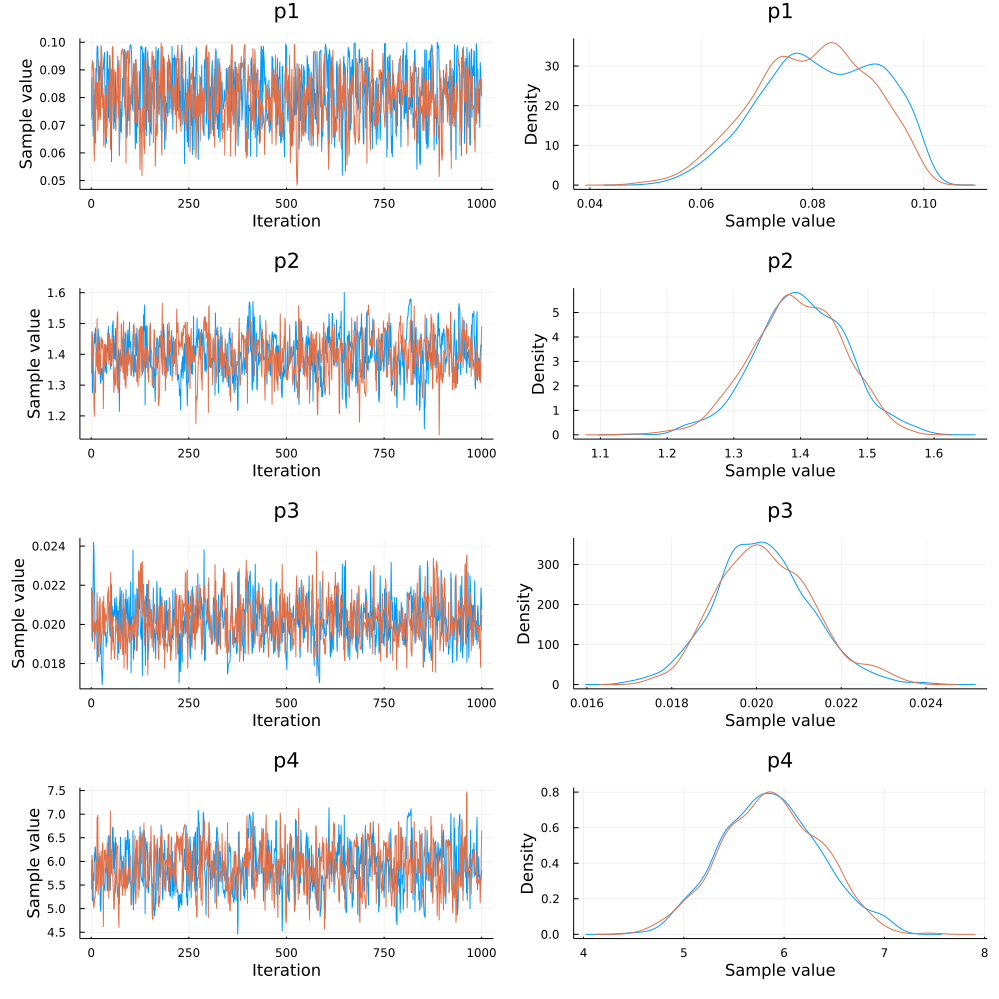

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47


In [36]:
default(fmt = :png)
plot(chainss)

Considering that the parameters used to generate the pseudodata where 0.09, 1.4, 0.02 and 5.7 the results avobe are not bad!

What we can do now is save the turing results in BOMBs format using the function **saveTuringResults**

In [37]:
Poster = saveTuringResults(chainss, model_def2, turinf_def2);


----------------------------------------- TURING RESULTS -----------------------------------------
Turing Inference results are saved in the directory: 
E:\UNI\D_Drive\PhD\JULIAlang\Generalisation_PLacExample\TuringTests\TuringExampleFinal\Results\Hes1Example_2021-11-24\TuringResults
--------------------------------------------------------------------------------------


----------------------------------------- RESULTS -----------------------------------------
Simulation results are saved in the directory: 
                 E:\UNI\D_Drive\PhD\JULIAlang\Generalisation_PLacExample\TuringTests\TuringExampleFinal\Results\Hes1Example_2021-11-24
Under the name Hes1Example_2021-11-24_SimulationResults_TuringInferResults.jld
--------------------------------------------------------------------------------------


----------------------------------------- PLOTS -----------------------------------------
Stan Inference Results PLOTS are saved in the directory: 
                 E:\UNI\D_Drive\Ph

The output of the function is only a matrix containing the samples of the posterior. 
    
Note that you could use this to estimate the posterior entropy as shown in the Stan section. Refer to that notebook for more information.

#### Let's have a look at the prints
**- TURING RESULTS:** Path to the directory containing the jld file with the inference results and a CSV file containing the posterior. <br>
**- RESULTS:** Path to the simulation results using the theta infered.  <br>
**- PLOTS:** Path to the plots generated (simulations and Posterior plots).<br>

#### So, let's have a look at the plots

In [38]:
using Images # Package not called in BOMBS, this is just to display the generated PNGs
using Dates

First, the posterior plot


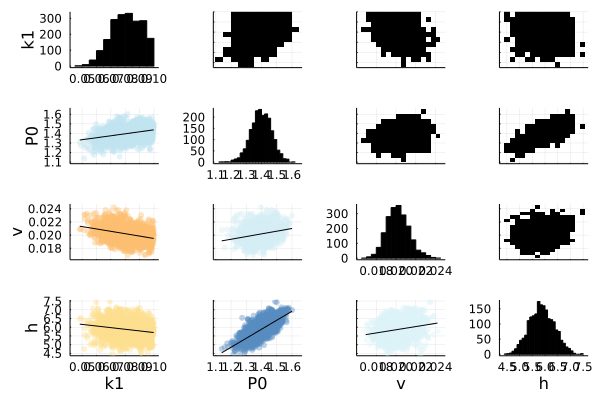

In [40]:
# Again, do not expect good results. Not even decent ones ;) 
# Also, you will not see much due to the high number of parameters. For a better look go to the actual file. 
PO1 = load(string("Results\\",model_def2["NameF"],"_",today(),"\\PosteriorPlotsTur_",turinf_def2["flag"],".png"))

And now the experiment

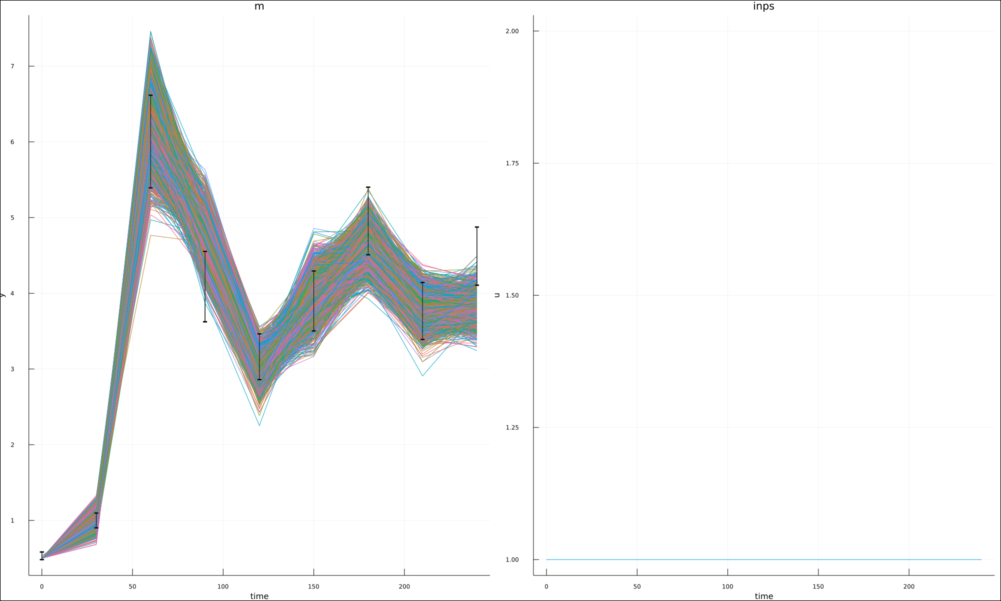

In [41]:
ex1 = load(string("Results\\",model_def2["NameF"],"_",today(),"\\PlotTuringInfResults_Exp",1,"_",turinf_def2["flag"],".png"))

### This is the end of the section. Look at the cool logo to check the package version ;) 


In [18]:
versionBOMBS()


                                                  *
                                    **           * *           *                          **
                                   * *          *   *         * *                       **  *
                                  *  *         *    *        *  **                    **     *
                         *       *   *  *   ***     *     ***    **                 **        *      *
                        * *     *    * * * *         **  *         **      *      **           *    * *   ***
                       *   *   *     **   *            **            **   * * ****              ****   ***   ***
                   ** *     ***                                        * *   *                                  *
                  *  *                                                  *                                        *
                 *            ___________   __________   ___  ___   ___________   __________                  